In [28]:
import pandas as pd 

# Load the dataset 
reviews = pd.read_csv("/Users/lal/Desktop/Github/hotel-reviews/data/reviews.csv")
offerings = pd.read_csv("/Users/lal/Desktop/Github/hotel-reviews/data/offerings.csv")

# Rename the "id" column in the offerings dataframe to "offerings_id" in order to merge with the reviews dataset. 
offerings = offerings.rename(columns = {"id" : "offering_id"})
print(offerings.info())

# Merge the two datasets 
df = pd.merge(reviews,offerings,
     on = "offering_id", 
     how = "inner")
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hotel_class  3141 non-null   float64
 1   region_id    4333 non-null   int64  
 2   url          4333 non-null   object 
 3   phone        0 non-null      float64
 4   details      0 non-null      float64
 5   address      4333 non-null   object 
 6   type         4333 non-null   object 
 7   offering_id  4333 non-null   int64  
 8   name         4333 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 304.8+ KB
None
                                                  ratings  \
0       {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1       {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2       {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
3       {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
4       {'service': 5.0, 'cleanliness': 5.0, 'overall'... 

In [30]:
# Get a subset of the data frame, include the columns that have the ratings (out of 5 for categories), review text, the id, and the name of the hotel.
print(df.columns)
df_subset = df.loc[:,["ratings","text","offering_id","name","address"]]

# Check for missing values
print(df_subset.isnull().sum())

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'hotel_class',
       'region_id', 'url', 'phone', 'details', 'address', 'type', 'name'],
      dtype='object')
ratings        0
text           0
offering_id    0
name           0
address        0
dtype: int64


In [ ]:
# Show column names and data types
print(df_subset.info())

# Show first few rows
print(df_subset.head())

# Show unique values per categorical column
print(df_subset.nunique())

In [31]:
import ast  # For safely converting string to dictionary

# Function to extract all rating categories
def extract_ratings(rating_str):
    try:
        rating_dict = ast.literal_eval(rating_str)  # Convert string to dictionary
        return {
            "overall_rating": rating_dict.get("overall", None),
            "service_rating": rating_dict.get("service", None),
            "cleanliness_rating": rating_dict.get("cleanliness", None),
            "location_rating": rating_dict.get("location", None),
            "value_rating": rating_dict.get("value", None),
            "rooms_rating": rating_dict.get("rooms", None),
        }
    except:
        return {
            "overall_rating": None,
            "service_rating": None,
            "cleanliness_rating": None,
            "location_rating": None,
            "value_rating": None,
            "rooms_rating": None,
        }  # Handle errors safely

# Apply function to extract ratings
rating_columns = df_subset["ratings"].apply(extract_ratings).apply(pd.Series)

# Merge extracted ratings into the main DataFrame
df_subset = pd.concat([df_subset, rating_columns], axis=1)

# Convert all rating columns to numeric
rating_columns_list = ["overall_rating", "service_rating", "cleanliness_rating", 
                       "location_rating", "value_rating", "rooms_rating"]
df_subset[rating_columns_list] = df_subset[rating_columns_list].apply(pd.to_numeric)

# Check results
print(df_subset[rating_columns_list].head())


   overall_rating  service_rating  cleanliness_rating  location_rating  \
0             5.0             5.0                 5.0              5.0   
1             5.0             5.0                 5.0              5.0   
2             5.0             5.0                 5.0              5.0   
3             5.0             5.0                 5.0              5.0   
4             5.0             5.0                 5.0              5.0   

   value_rating  rooms_rating  
0           5.0           5.0  
1           5.0           5.0  
2           5.0           5.0  
3           4.0           5.0  
4           4.0           5.0  


In [ ]:
## READ.ME 

import urllib.request

# Download FastText language detection model
url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
save_path = "lid.176.bin"

# Download the model file
urllib.request.urlretrieve(url, save_path)

print("Download complete: lid.176.bin")

In [33]:
import fasttext

model = fasttext.load_model("lid.176.bin")

# Function to detect language using FastText
def detect_language_fasttext(text):
    try:
        return model.predict(text)[0][0].replace("__label__", "")  # Extract language code
    except:
        return "unknown"  # Handle errors gracefully

# Apply to dataset
df_subset["language"] = df_subset["text"].apply(detect_language_fasttext)

# Check language distribution
print(df_subset["language"].value_counts())

en         439063
unknown    381012
de          15431
fr          12588
it          11438
es           7894
pt           2927
ja           2019
nl           2003
sv           1746
da            926
no            773
zh            413
ru            172
tr             81
pl             41
el             11
th              9
ko              7
nn              3
id              2
oc              1
fa              1
Name: language, dtype: int64


In [34]:
# Filter only English reviews

df = df_subset[df_subset["language"] == "en"]
df.reset_index(drop=True, inplace=True)  # Reset index after filtering

# Check new dataset size
print("Number of English reviews:", len(df))

Number of English reviews: 439063


In [36]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download stopwords and lemmatizer data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization
    return " ".join(words)

# Apply text cleaning to reviews
df["cleaned_text"] = df["text"].apply(clean_text)

# Show cleaned text
print(df[["text", "cleaned_text"]].sample(5))

[nltk_data] Downloading package stopwords to /Users/lal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                     text  \
185121  The hotel is very well placed for the main Phi...   
15896   Was heavily influenced by Tripadvisor when mak...   
272088  When we first arrived we were able to have a e...   
63824   Great location....nice rooms for the price. Ba...   
385476  Just got back from another great visit. Was at...   

                                             cleaned_text  
185121  hotel well placed main philadelphia attraction...  
15896   heavily influenced tripadvisor making decision...  
272088  first arrived able early check great atmospher...  
63824   great location nice room price bar outrageousl...  
385476  got back another great visit hotel june back n...  


/var/folders/m1/rvmr_wv50dvb_jqvr2y7l7lh0000gn/T/ipykernel_14981/290885055.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleaned_text"] = df["text"].apply(clean_text)


In [37]:
import pickle

# Save the preprocessed DataFrame
df.to_pickle("/Users/lal/Desktop/Github/hotel-reviews/data/preprocessed_reviews.pkl")
df.to_csv("/Users/lal/Desktop/Github/hotel-reviews/data/preprocessed_reviews.csv", index=False)
print("Preprocessed reviews are saved!")

In [11]:
import pandas as pd
df = pd.read_pickle("/Users/lal/Desktop/Github/hotel-reviews/data/preprocessed_reviews.pkl")

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis to each review
df["sentiment_score"] = df["cleaned_text"].apply(get_sentiment)

# Show results
print(df[["text", "cleaned_text", "sentiment_score"]].sample(5))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                     text  \
75073   Booked two deluxe king rooms for £90 a night, ...   
406569  A bunch of girls got a room at the Westin to c...   
18884   I just spent what will probably come to be kno...   
211561  There is a big difference between two queen si...   
358821  We stayed here for the weekend of April 13th-1...   

                                             cleaned_text  sentiment_score  
75073   booked two deluxe king room 90 night one corne...           0.8834  
406569  bunch girl got room westin celebrate friend ba...           0.9855  
18884   spent probably come known blizzard 2010 kimber...           0.9482  
211561  big difference two queen sized bed two full al...          -0.7351  
358821  stayed weekend april 13th 14th using groupon p...           0.9738  


In [13]:
def categorize_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["sentiment_score"].apply(categorize_sentiment)

# Display sentiment distribution
print(df["sentiment_label"].value_counts())

Positive    409643
Negative     26124
Neutral       3296
Name: sentiment_label, dtype: int64


In [14]:
# Save the data frame with sentiment scores and labels 
df.to_pickle("/Users/lal/Desktop/Github/hotel-reviews/data/sentiment_reviews.pkl")
df.to_csv("/Users/lal/Desktop/Github/hotel-reviews/data/sentiment_reviews.csv", index=False)
print("Data frame with sentiment scores and labels reviews is saved!")

Data frame with sentiment scores and labels reviews is saved!


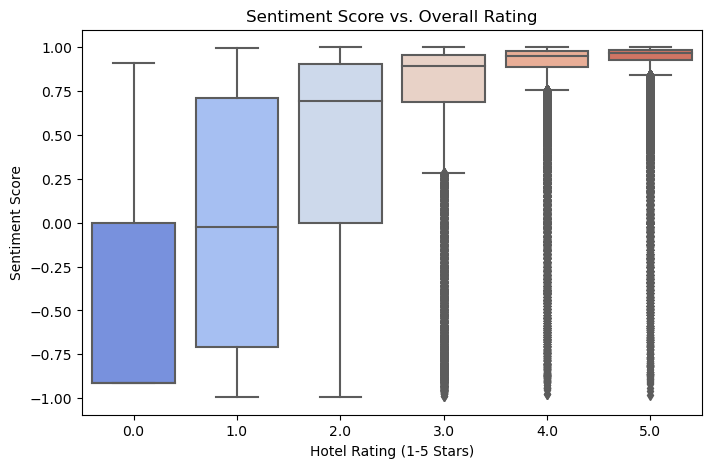

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot sentiment score vs. hotel rating
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["overall_rating"], y=df["sentiment_score"], palette="coolwarm")
plt.title("Sentiment Score vs. Overall Rating")
plt.xlabel("Hotel Rating (1-5 Stars)")
plt.ylabel("Sentiment Score")
plt.show()


In [ ]:
# Filter 5-star reviews with very negative sentiment
outliers = df[(df["overall_rating"] == 5) & (df["sentiment_score"] < -0.5)]

pd.set_option('display.max_colwidth', None)  # Show full text without truncation

# Display sample outliers
print(outliers[["text", "sentiment_score"]].sample(10))

In [45]:
correlation = df["sentiment_score"].corr(df["overall_rating"], method="pearson")
print(f"📈 Pearson Correlation: {correlation:.4f}")

spearman_corr = df["sentiment_score"].corr(df["overall_rating"], method="spearman")
print(f"📊 Spearman Correlation: {spearman_corr:.4f}")

from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(df["sentiment_score"], df["overall_rating"])
spearman_corr, spearman_p = spearmanr(df["sentiment_score"], df["overall_rating"])

print(f"📈 Pearson Correlation: {pearson_corr:.4f}, P-value: {pearson_p:.4f}")
print(f"📊 Spearman Correlation: {spearman_corr:.4f}, P-value: {spearman_p:.4f}")


📈 Pearson Correlation: 0.5792
📊 Spearman Correlation: 0.4417
📈 Pearson Correlation: 0.5792, P-value: 0.0000
📊 Spearman Correlation: 0.4417, P-value: 0.0000


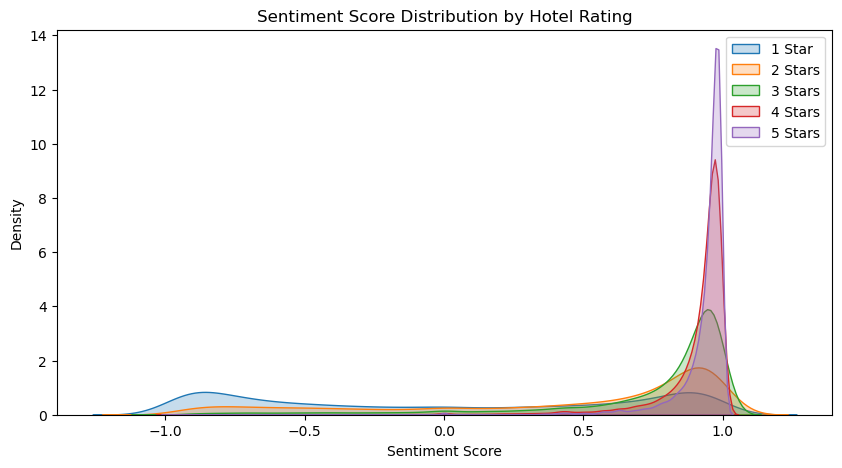

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.kdeplot(df[df["overall_rating"] == 1]["sentiment_score"], label="1 Star", fill=True)
sns.kdeplot(df[df["overall_rating"] == 2]["sentiment_score"], label="2 Stars", fill=True)
sns.kdeplot(df[df["overall_rating"] == 3]["sentiment_score"], label="3 Stars", fill=True)
sns.kdeplot(df[df["overall_rating"] == 4]["sentiment_score"], label="4 Stars", fill=True)
sns.kdeplot(df[df["overall_rating"] == 5]["sentiment_score"], label="5 Stars", fill=True)

plt.title("Sentiment Score Distribution by Hotel Rating")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.legend()
plt.show()


In [20]:
# Define thresholds for positive and negative sentiment
positive_df = df[df["sentiment_score"] > 0.5]  # Strongly positive reviews
negative_df = df[df["sentiment_score"] < -0.5]  # Strongly negative reviews

print(f"✅ Positive Reviews: {len(positive_df)} | Negative Reviews: {len(negative_df)}")

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit-transform positive and negative reviews separately
tfidf_pos_matrix = tfidf.fit_transform(positive_df["cleaned_text"])
tfidf_neg_matrix = tfidf.fit_transform(negative_df["cleaned_text"])

# Get feature names (words)
words = tfidf.get_feature_names_out()

# Compute average TF-IDF score per word
tfidf_pos_scores = tfidf_pos_matrix.mean(axis=0).tolist()[0]
tfidf_neg_scores = tfidf_neg_matrix.mean(axis=0).tolist()[0]

# Convert to DataFrame
tfidf_pos_df = pd.DataFrame({"word": words, "tfidf": tfidf_pos_scores}).sort_values(by="tfidf", ascending=False)
tfidf_neg_df = pd.DataFrame({"word": words, "tfidf": tfidf_neg_scores}).sort_values(by="tfidf", ascending=False)

# Show top words
print("🔹 Top Positive Words:\n", tfidf_pos_df.head(10))
print("🔻 Top Negative Words:\n", tfidf_neg_df.head(10))


✅ Positive Reviews: 391438 | Negative Reviews: 15554
🔹 Top Positive Words:
           word     tfidf
2283  includes  0.064741
3801    safety  0.059353
2072   handful  0.043799
4254     stone  0.036318
4222   stating  0.035799
2673   luggage  0.031380
3020  occupant  0.030861
966       cock  0.029774
2038   groupon  0.029451
4257      stop  0.026033
🔻 Top Negative Words:
         word     tfidf
3761    room  0.068846
2209   hotel  0.059837
4225    stay  0.032832
2966   night  0.030808
570      bed  0.025417
1358   dirty  0.024017
3263   place  0.023625
4190   staff  0.023255
4227  stayed  0.022604
1314    desk  0.022346


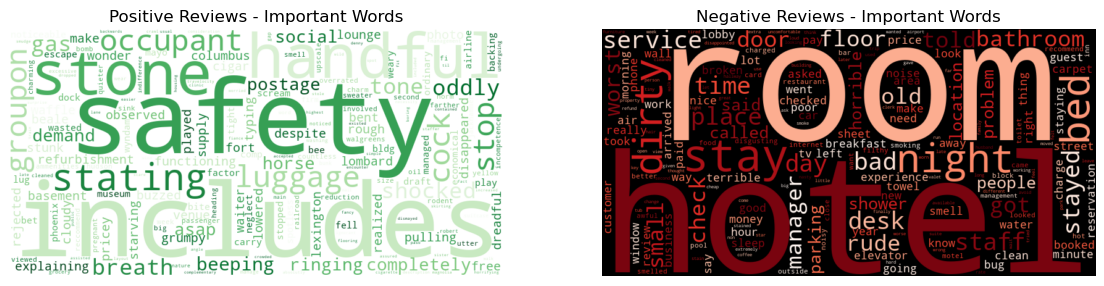

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top 200 words for each sentiment
top_pos_words = " ".join(tfidf_pos_df.head(200)["word"])
top_neg_words = " ".join(tfidf_neg_df.head(200)["word"])

# Create word clouds
pos_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(top_pos_words)
neg_wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(top_neg_words)

# Plot word clouds side by side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews - Important Words")

plt.subplot(1, 2, 2)
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews - Important Words")

plt.show()


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Transform all hotel reviews into TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(df["cleaned_text"])

# Get feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Check shape of TF-IDF matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")  # (num_reviews, num_features)


TF-IDF Matrix Shape: (439063, 5000)


In [27]:
def process_query(user_query):
    # Convert the user input into a TF-IDF vector
    query_vector = tfidf_vectorizer.transform([user_query])
    return query_vector

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_recommendations(user_query, top_n=5):
    query_vector = process_query(user_query)

    # Compute cosine similarity between the query and all reviews
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

    # Get indices of top N most similar reviews
    top_indices = similarity_scores.argsort()[0][-top_n:][::-1]

    # Return the top N hotels
    return df.iloc[top_indices][["name", "text", "overall_rating", "sentiment_score"]]

# Example: Get recommendations for a user query
user_query = "I'm looking for a hotel that has spacious rooms and have good and friendly staff"
recommendations = get_top_recommendations(user_query, top_n=5)

# Display recommendations in Jupyter Notebook
from IPython.display import display

display(recommendations)  # Works in Jupyter Notebook

,name,text,overall_rating,sentiment_score
209721,The Sheraton San Diego Hotel & Marina,The rooms were spacious and the staff was frie...,4.0,0.4939
28484,Hotel Stanford,"Very good hotel, clean and spacious suites. Fr...",5.0,0.8934
347097,Comfort Inn Downtown,"a nice clean, friendly hotel looking over the ...",5.0,0.8271
317316,The Donatello Hotel,"Good hotel, clean and spacious room, friendly ...",4.0,0.9216
130702,Hyatt Regency Chicago,Spacious rooms and friendly service depsite be...,3.0,0.8316
